In [1]:
!pip install python-box -U timm torchmetrics --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 42.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: timm
    Found existing installation: timm 0.9.5
    Uninstalling timm-0.9.5:
      Successfully uninstalled timm-0.9.5


- Before Performing inference the model should be on eval mode this is important because it disable dropout and batch normalization layer.
- Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory, This can improve training speed and reduce memory usage.
- AdamW
optimizer with weight decay of 0.05
and peak learning rate 10−3
for a total batch size of 1024
- Setting drop_last=True during training means that if there are remaining samples that don't form a complete batch,
they will be dropped, ensuring that all training batches have the same size
- Models are trained at resolution 256×256 and fine-tuned for 384×384

In [ ]:
# !pip install -qqq wandb pytorch-lightning torchmetrics

In [3]:
import pytorch_lightning as pl
import torchmetrics
pl.seed_everything(hash("setting random seeds") % 2**32 - 1)
import wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import timm
import warnings
from pprint import pprint
import os, cv2
import numpy as np
import torch
import torch
from torch import nn, optim
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
from torchmetrics.functional import f1_score
from torchmetrics.classification import MultilabelAccuracy
from torchmetrics.classification import Accuracy
from pytorch_lightning.strategies import DeepSpeedStrategy
from pytorch_lightning.loggers.csv_logs import CSVLogge
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim
from albumentations import Compose, HorizontalFlip, RandomResizedCrop, Normalize, ToFloat, CenterCrop, Resize
from albumentations.pytorch import ToTensorV2
from albumentations import RandomBrightnessContrast, ShiftScaleRotate
import albumentations
from PIL import Image
from box import Box
from sklearn.metrics import top_k_accuracy_score, f1_score, accuracy_score,classification_report, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings("ignore")
!pip show accelerate

Name: accelerate
Version: 0.22.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /opt/conda/lib/python3.10/site-packages
Requires: numpy, packaging, psutil, pyyaml, torch
Required-by: catalyst


In [5]:
#### Initialized all the paramters for further used
config = {'seed':2023,
    'root': '/kaggle/input/kvasir-gi-image-classification/kvasir-dataset-v2',
    'epoch':40,
    'image_size': 384,
    'accelerator':'gpu',
    'device' :'auto',
    'precision':16,
    'train_loader':{
        'batch_size':64,
        'shuffle':True,
        'num_workers':4,
        'pin_memory':True,
        'drop_last':True,
    },
    'val_loader':{
        'batch_size':64,
        'shuffle':False,
        'num_workers':4,
        'pin_memory':True,
        'drop_last':False,
    },
    'test_loader':{
        'batch_size':64,
        'pin_memory':False,
        'num_workers': 4,
        'drop_last':False,
        'shuffle':False,
    },
    'model':{
        'name':'fastvit_t8', #fastvit_t8 #fastvit_ma36 fastvit_sa24
        'output_dim':8
        
    },
    'optimizer':{
        'name':'optime.AdamW',
        'params':{
            'lr':1e-3,
            'weight_decay':0.005
        },
    },
    'loss': 'nn.CrossEntropyLoss',  
}
config = Box(config)
image_size= config.image_size

In [6]:
pprint(config)

Box({'seed': 2023, 'root': '/kaggle/input/kvasir-gi-image-classification/kvasir-dataset-v2', 'epoch': 40, 'image_size': 384, 'accelerator': 'gpu', 'device': 'auto', 'precision': 16, 'train_loader': {'batch_size': 64, 'shuffle': True, 'num_workers': 4, 'pin_memory': True, 'drop_last': True}, 'val_loader': {'batch_size': 64, 'shuffle': False, 'num_workers': 4, 'pin_memory': True, 'drop_last': False}, 'test_loader': {'batch_size': 64, 'pin_memory': False, 'num_workers': 4, 'drop_last': False, 'shuffle': False}, 'model': {'name': 'fastvit_t8', 'output_dim': 8}, 'optimizer': {'name': 'optime.AdamW', 'params': {'lr': 0.001}}, 'loss': 'nn.CrossEntropyLoss'})


In [35]:
timm.list_models("fastvit**")

['fastvit_ma36',
 'fastvit_s12',
 'fastvit_sa12',
 'fastvit_sa24',
 'fastvit_sa36',
 'fastvit_t8',
 'fastvit_t12']

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.label_to_class = {label: i for i, label in enumerate(self.classes)}
        self.data = self.load_data()
    
    #load dataset from directory
    def load_data(self):
        data = []
        for label in self.classes:
            label_dir = os.path.join(self.root_dir, label)
            for filename in os.listdir(label_dir):
                img_path = os.path.join(label_dir, filename)
                data.append((img_path, self.label_to_class[label]))
        return data

    def __len__(self):
        return len(self.data)
    
    #convert to RGB and transform to albamentation mode
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        
        image =np.array(image)
        if self.transform:
            image = self.transform(image=image)['image'] 

        return image, label

class SubsetLoader:
    def __init__(self, root_dir, train_transform=None, val_transform=None, test_transform=None, validation_split=0.2):
        self.root_dir = root_dir
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.test_transform = test_transform
        self.validation_split = validation_split

        self.dataset = CustomDataset(root_dir=self.root_dir, transform=None)
        self.num_samples = len(self.dataset)
        self.indices = list(range(self.num_samples))
        self.split_indices()
        
    #split dataset on train test and validation
    def split_indices(self):
        # Split indices into train, validation, and test sets
        num_val = int(self.validation_split * self.num_samples)
        num_test = int(0.1 * self.num_samples)
        num_train = self.num_samples - num_val - num_test

        train_indices, val_indices, test_indices = torch.utils.data.random_split(
            self.indices, [num_train, num_val, num_test]
        )
        # prepare dataset for differece loader with difference augmentation and loaded
        self.train_loader = self.get_loader(train_indices, self.train_transform, mode=config.train_loader)
        self.val_loader = self.get_loader(val_indices, self.val_transform,mode=config.val_loader)
        self.test_loader = self.get_loader(test_indices, self.test_transform, mode=config.test_loader)

    def get_loader(self, indices, transform, mode):
        print(mode)
        return DataLoader(
            CustomDataset(root_dir=self.root_dir, transform=transform),
            sampler=SubsetRandomSampler(indices),
            batch_size=mode.batch_size,
            num_workers=mode.num_workers,
            pin_memory=mode.pin_memory,
            drop_last=mode.drop_last,
        )
    
##trian augmentaton
train_transform = Compose([
    Resize(height=image_size, width=image_size, interpolation=cv2.INTER_LINEAR),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=30, p=0.5, interpolation=cv2.INTER_LINEAR),
    albumentations.HorizontalFlip(p=0.5), #Flips the image horizontally (left to right) with a probability of 50%
    albumentations.VerticalFlip(p=0.5), #Flips the image vertically (top to bottom) with a probability of 50%
    albumentations.Transpose(p=0.5), #Transposes the image (flips it along the diagonal)
    albumentations.RandomBrightness(limit=0.1, p=0.7),#Randomly adjusts the brightness of the image by up to 10% 
    albumentations.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=10, p=0.5), #randomly shifts, scales, and rotates the image
    albumentations.RandomBrightnessContrast(0.1, 0.1, p=0.5), #Randomly adjusts both brightness and contrast of the image
    albumentations.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),#Randomly shifts the red, green, and blue color channels of the image##
    albumentations.OneOf([
    albumentations.OpticalDistortion(distort_limit=1.),#this is a choice between two distortion techniques, both with a 0.5 probability
    albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    ], p=0.5),
    Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

#test augmentation

val_transform = Compose([
    Resize(height=image_size, width=image_size, interpolation=cv2.INTER_LINEAR),
    Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])


#valid augmentation
test_transform = Compose([
    Resize(height=image_size, width=image_size, interpolation=cv2.INTER_LINEAR),
    Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

#call loder to load and transfrom dataset
subset_loader = SubsetLoader(
    root_dir=config.root,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=test_transform,
)

train_loader = subset_loader.train_loader
val_loader = subset_loader.val_loader
test_loader = subset_loader.test_loader

{'batch_size': 64, 'shuffle': True, 'num_workers': 4, 'pin_memory': True, 'drop_last': True}
{'batch_size': 64, 'shuffle': False, 'num_workers': 4, 'pin_memory': True, 'drop_last': False}
{'batch_size': 64, 'pin_memory': False, 'num_workers': 4, 'drop_last': False, 'shuffle': False}


In [8]:
len(train_loader)

87

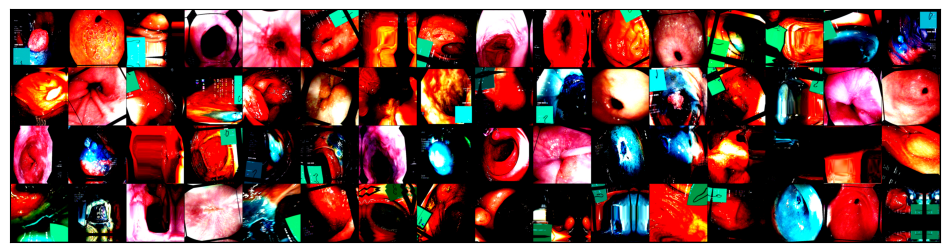

In [9]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_grid(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    plt.show()

show_grid(train_loader)

In [18]:
#check point initialized and wandbloger also
checkpoint_dir = "/kaggle/working/weights"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, "model_checkpoint_{epoch:02d}.ckpt")
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor="valid/loss_epoch",
    mode="min",
    save_top_k=-1,  # Keep all checkpoints
    verbose=True,
    save_last=False,
)
wandb_logger = WandbLogger(project="Gastrointestinal Disease-1")  

In [19]:
class Kvasir_LightningTimmModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model(
            config.model.name,
            in_chans=3,
            features_only=False,
            pretrained=True,
            num_classes=config.model.output_dim,
        )
        #initialized difference parameter and variable
        self.save_hyperparameters()
        self.accuracy = Accuracy(task="multiclass", num_classes=8)
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=8)
        self.valid_acc = torchmetrics.Accuracy(task="multiclass", num_classes=8)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=8)
        self.best_accuracy=0
        self.best_epoch = -1
        self.best_loss = float('inf')

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self): #optimizer used from paper
        optimizer = torch.optim.AdamW(self.parameters(),  weight_decay=config.optimizer.params.weight_decay, lr=config.optimizer.params.lr)
        return optimizer
    
   #training procedure and return matrix for wandb
    def training_step(self, batch, batch_idx):
        x, y =batch
        loss, scores, y = self._common_step(batch, batch_idx)
        preds = torch.argmax(scores, 1)
        self.log('train/loss', loss, on_epoch=True)
        self.train_acc(preds, y)
        self.log('train/acc', self.train_acc, on_epoch=True)
        return {"loss": loss, "scores": scores, "y": y}
    #validation procedure and return matrix for wandb
    def validation_step(self, batch, batch_idx):
        x, y =batch
        loss, scores, y = self._common_step(batch, batch_idx)
        preds = torch.argmax(scores, 1)
        self.valid_acc(preds, y)
        self.log("valid/loss_epoch", loss)
        self.log('valid/acc_epoch', self.valid_acc)
        return scores, loss
    
    #test data and checking for acc , loss
    def test_step(self, batch, batch_idx):
        x, y =batch
        loss, scores, y = self._common_step(batch, batch_idx)
        preds = torch.argmax(scores, 1)
        self.test_acc(preds, y)
        self.log("test/loss_epoch", loss, on_step=False, on_epoch=True)
        self.log("test/acc_epoch", self.test_acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss)
        return loss
    
    #common function that used on all train, test, validation
    def _common_step(self, batch, batch_idx):
        x, y = batch 
        scores = self.model(x)
        loss = nn.CrossEntropyLoss()(scores, y)
        return loss, scores, y
    
    ## prediction method for further used
    def predict_step(self, batch, batch_idx):
        x, _ = batch 
        scores = self.model(x)
        probability = torch.softmax(scores, dim=1)
        preds = torch.argmax(scores, dim=1)
        return preds,probability

               
model = Kvasir_LightningTimmModel() #model initialized
trainer = pl.Trainer(
    accelerator="gpu" if config.accelerator else "cpu",  # 'ddp' for DataParallel training with GPUs
    precision=config.precision,  # Enables mixed-precision training
    max_epochs=config.epoch,  # Use your configured number of epochs
    logger=wandb_logger, 
    log_every_n_steps=50,
    callbacks=[checkpoint_callback]
)

trainer.fit(model, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [20]:
results = trainer.test(model, test_loader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/acc_epoch       │    0.9237499833106995     │
│      test/loss_epoch      │    0.2629956901073456     │
│         test_loss         │    0.2629956901073456     │
└───────────────────────────┴───────────────────────────┘

In [21]:
#evalate for acc, f1 score and top-3 also top-5
def evaluate_model(model, dataloader, val):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            preds = model.predict_step((x, None), None)  # Assuming the first element of preds is a tensor
            preds = preds[val].cpu().numpy()  # Extract the tensor, move it to CPU, and convert to NumPy array
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())
    return all_preds, all_labels
test_preds, test_labels = evaluate_model(model, test_loader, 0)
test_proba, test_lab = evaluate_model(model, test_loader, 1)

In [22]:
accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds, average='macro')
data = [np.array(test_proba)]
numpy_array = data[0]
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Top-5 accuracy",top_k_accuracy_score(test_lab, numpy_array, k=5))
print("Top-3 accuracy", top_k_accuracy_score(test_lab, numpy_array, k=3))

Accuracy: 0.9237
F1 Score: 0.9220
Top-5 accuracy 1.0
Top-3 accuracy 0.99875


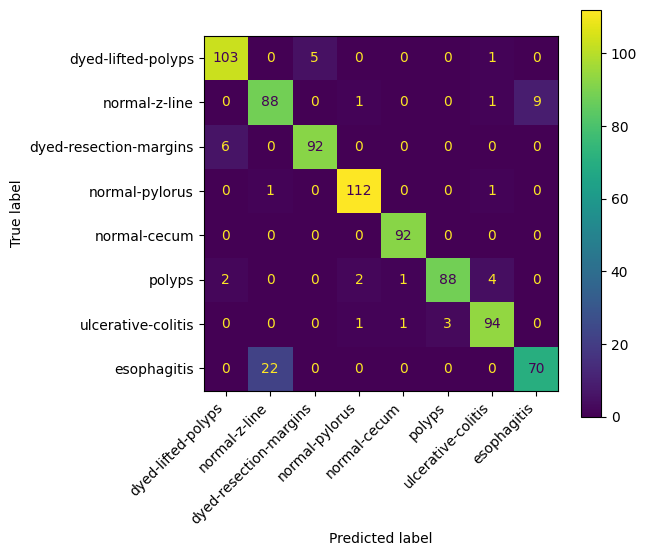

In [29]:
#confusion matrix with multiclass
classes=test_loader.dataset.classes
cm = confusion_matrix(test_labels, np.array(test_preds))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=classes)
cm_display.plot()
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

In [23]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test/acc_epoch,▁
test/loss_epoch,▁
test_loss,▁
train/acc_epoch,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇████████████████
train/acc_step,▄▁▅▆▇▇▇▅█▆▅█▆▇▇▆▇▇▆█▇█▇▇▇▇█▇█▇▇▇█▇▇▇▇▇▇█
train/loss_epoch,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,▅█▄▃▃▂▂▃▁▂▃▂▃▂▂▃▂▂▃▁▂▁▁▂▂▂▁▁▁▂▁▁▁▁▂▂▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/acc_epoch,▃▁▆▆▆▇▇▅▇█▇▆▇▇▇▇▇█▇▇▇█▇▇▇▇▇▇▇████▇██████
valid/loss_epoch,▆█▃▃▃▂▂▅▂▂▁▃▂▂▂▂▁▂▂▃▂▁▂▂▂▃▂▂▂▂▁▂▂▂▂▁▂▂▂▂


##### Working Flow

In this task, Given a multi-class image classification dataset and FastVit paper and have to implement the paper from timm library with that dataset on subclass Image dataset and several accuracy metrics like F1-score, top-3 and top-5 accuracy.

#### Dataset
Autometic detection on diseases by use computer is an important but strill unexplored on reaserch. Human digestive system may be affected several diseases like esophageal, stomach and colerectal cancer amccounts for 2.8 million new casses and 1.8 million deaths every year.Kvasir a dataset containing image from inside the gastrointesnial(GI) track. Collection of image are classifies into three important anatomical landmarks and three clinically significant with two image of related endoscopic polyp removal. There is total 8000 images and each class contain 1000 images.The dataset consist image with difference resolution from 720x576 to 1920x1072 pixels and organized with separate folder name accordingly.


#### EDA
As mentioned in dataset is a multiclass classification with medical images. Check basic notes like size, shape, pixel contribution, color contribution and view each images from each class. Count the shape from each resolution and got there is 5137 images from  576x720 resolution and 2122 images from 1024x1280 resolution and every images from 3 channel. Then try to find the inerpolation are of images by doing crop, rotation, flip,resiging, transpose and so on.

#### Pytorch Lighting
PyTorch is extremely easy to use to build complex AI models. But once the research gets complicated and things like multi-GPU training, 16-bit precision and TPU training get mixed in, users are likely to introduce bugs. Pytorch Lighting solves exactly this issue and lighting struture pytorch code so it can details and abstract on training.Basically it was created proffesional researcher and PHD students for working with AI research.

#### Data Preparation and Model Build
FastVit paper is a recent paper from transformer and its gained SOTA result on several sector with ImageNet-1k dataset. In this paper authors trained their image with 256x256 and find-tuned with 384x384 resolution. So I choose fine-tuned image size for this model which is 384x384. Then differentiate this images with label and data with sub-Image classes. After classified those images with labels as well as divided into three section training, validation, testing size with 5564, 1600, 832 accordingly.In that paper used 1024 batch-size but my computional shortage apply 64 batch-size. Then do difference augmentation on difference part like simple resize and normalizaion apply on testing and validation part and training part applied difference technique from albamentation library. Forgot to mension that here I follow image classification technique from the paper.
Again faced computational problem for selecting upper benchmark model with high top-1 accuracy.When I try to select FastViT-SA12, or SA34 got computational error and out of VRAM. But then try to apply multiple GPU from kaggle that worked but facing error with mixed-precision protocol coz in my task mentioned that work with mixed precision and notebook-ddb not working with mixed-precision and such kind of dificulties then I choose the small one which is FastVit-T8. and follow other parameters like learning rate 0.001, AdamW optimizer with weight decay 0.05 and so on. last but not the least used wandb to track to accuracy and error.

#### Result and Accuracy: 
Now time to write the result of this injected model on the Kvasir dataset. This result containing the last epoch of the model which is 40th epoch of the model. Getting better accuracy on training and testing but validation have little bit less than those two.

|Model|Accuracy|loss|F1-Score|Top-3|Top-5|
| ----- | ----- |-----|-----|-----|-----|
|FastVit-t8|92.37| 0.263|0.9220|0.99875|1.0|

#### Conclusion:
Another more interesting task done. Face dificulties on mixed-precision with multiple GPU and cannot get done. Basically main thing is when I run code with kaggle notebook and stratregy="ddb_notebook" with multiple-gpu and mixed-precision then it give me error but without mix-precision got me there. for this reason just tried out the little model with less top-1 accuracy from fastvit. 

